This code was written for the interview process of a computational chemistry position by DeepCure.

Date: January 2019

Last update: February 24 2019

Interviwer: Kfir Schreiber, kfir@deepcure.ai

## <font color='blue', size="5">Import required libraries</font>

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from rdkit import Chem 
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Recap
from rdkit.Chem import AllChem
from rdkit.Chem import Crippen
from rdkit.Chem import Fingerprints
from rdkit.Chem.Fingerprints import SimilarityScreener
from rdkit.Chem.Fingerprints import MolSimilarity
from rdkit.Chem import Scaffolds
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold

## <font color='blue', size="5">Read selected molecules</font>

In [4]:
df_init = pd.read_csv('200.smiles', sep='\t')

## <font color='blue', size="5">Select the chemical reactions</font>
Here we select two reactions:
rxn1: Amide reaction,
rxn2: Reaction between alcohol1 and acid

In [5]:
rxn1 = rdChemReactions.ReactionFromSmarts('[C:1](=[O:2])O.[N:3]>>[C:1](=[O:2])[N:3]')
rxn2 = AllChem.ReactionFromSmarts('[CH1:1][OH:2].[OH][C:3]=[O:4]>>[C:1][O:2][C:3]=[O:4]')

## <font color='blue', size="5">Calculate molecular properties for the initial selected pupulation</font>

In [6]:
df_init = df_init.drop(['URL'],axis=1)
df_init['molecule'] = df_init['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_init['MW'] = df_init['molecule'].apply(lambda x: Chem.Descriptors.MolWt(x))
df_init['logp'] = df_init['molecule'].apply(lambda x: Chem.Crippen.MolLogP(x))
df_init['TPSA'] = df_init['molecule'].apply(lambda x: Chem.Descriptors.TPSA(x))
df_init['HBD'] = df_init['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumHBD(x))
df_init['HBA'] = df_init['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumHBA(x))
df_init['AliCyc'] = df_init['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumAliphaticCarbocycles(x))
df_init['AroCyc'] = df_init['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumAromaticCarbocycles(x))
df_init['RB'] = df_init['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumRotatableBonds(x))
df_init = df_init.drop(['MOLPORTID'],axis=1)

## <font color='blue', size="5">Perform the reactions</font>

In [7]:
df_react = pd.DataFrame(columns=['molecule'])
m = 0
for index, row in df_init.iterrows():
    mol1 = df_init['molecule'][index]
    for index, row in df_init.iterrows():
        mol2 = df_init['molecule'][index]
        reacts = (mol1,mol2)
        products1 = rxn1.RunReactants(reacts)
        products2 = rxn2.RunReactants(reacts)
        for i in range(len(products1)):
            df_react.loc[m] = [products1[i][0]]
            m += 1
        for i in range(len(products2)):
            df_react.loc[m] = [products2[i][0]]
            m += 1

## <font color='blue', size="5">Calculate molecular properties for the products</font>

In [8]:
df_react = df_react.drop_duplicates()
df_react['SMILES'] = df_react['molecule'].apply(lambda x: Chem.MolToSmiles(x))
df_react['molecule'] = df_react['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_react = df_react.dropna()

In [9]:
df_react['MW'] = df_react['molecule'].apply(lambda x: Chem.Descriptors.MolWt(x))
df_react['logp'] = df_react['molecule'].apply(lambda x: Chem.Crippen.MolLogP(x))
df_react['TPSA'] = df_react['molecule'].apply(lambda x: Chem.Descriptors.TPSA(x))
df_react['HBD'] = df_react['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumHBD(x))
df_react['HBA'] = df_react['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumHBA(x))
df_react['AliCyc'] = df_react['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumAliphaticCarbocycles(x))
df_react['AroCyc'] = df_react['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumAromaticCarbocycles(x))
df_react['RB'] = df_react['molecule'].apply(lambda x: Chem.rdMolDescriptors.CalcNumRotatableBonds(x))

## <font color='blue', size="5">Concatenate all the molecules</font>

In [10]:
df_all = pd.concat([df_init.drop('molecule',axis=1),df_react.drop('molecule',axis=1)])





## <font color='brown', size="6">RESULTS VISUALIZATION:</font>

## <font color='blue', size="5">Molecular weight distribution</font>

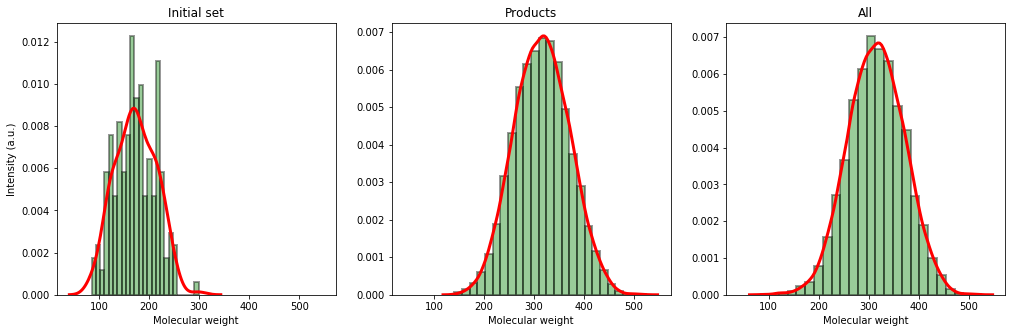

In [11]:
f, axes = plt.subplots(1, 3, figsize=(17, 5), sharex=True)
ax1 = sns.distplot(df_init['MW'],bins=25,color="g",
                  hist_kws=dict(edgecolor="k", linewidth=2),
                  kde_kws=dict(color="r", lw=3),
                  ax=axes[0])
ax2 = sns.distplot(df_react['MW'],bins=25,color="g",
                  hist_kws=dict(edgecolor="k", linewidth=2),
                  kde_kws=dict(color="r", lw=3),
                  ax=axes[1])
ax3 = sns.distplot(df_all['MW'],bins=25,color="g",
                  hist_kws=dict(edgecolor="k", linewidth=2),
                  kde_kws=dict(color="r", lw=3),
                  ax=axes[2])
ax1.set(xlabel='Molecular weight', ylabel='Intensity (a.u.)',title="Initial set")
ax2.set(xlabel='Molecular weight',title="Products")
ax3.set(xlabel='Molecular weight',title="All")
plt.show()
f.savefig("MW.pdf", bbox_inches='tight')

## <font color='blue', size="5">logP distribution</font>

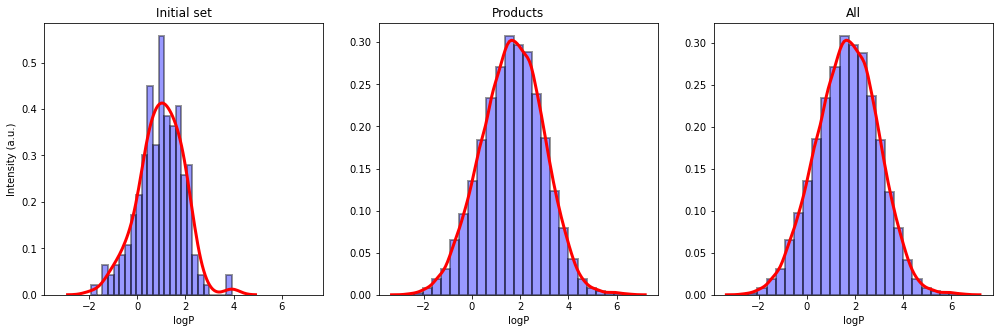

In [12]:
f, axes = plt.subplots(1, 3, figsize=(17, 5), sharex=True)
ax1 = sns.distplot(df_init['logp'],bins=25,color="b",
                  hist_kws=dict(edgecolor="k", linewidth=2),
                  kde_kws=dict(color="r", lw=3),
                  ax=axes[0])
ax2 = sns.distplot(df_react['logp'],bins=25,color="b",
                  hist_kws=dict(edgecolor="k", linewidth=2),
                  kde_kws=dict(color="r", lw=3),
                  ax=axes[1])
ax3 = sns.distplot(df_all['logp'],bins=25,color="b",
                  hist_kws=dict(edgecolor="k", linewidth=2),
                  kde_kws=dict(color="r", lw=3),
                  ax=axes[2])
ax1.set(xlabel='logP', ylabel='Intensity (a.u.)',title="Initial set")
ax2.set(xlabel='logP',title="Products")
ax3.set(xlabel='logP',title="All")
plt.show()
f.savefig("logp.pdf", bbox_inches='tight')

## <font color='blue', size="5">Molecular properties</font>

In [13]:
df_init['set'] = 'initial'
df_react['set'] = 'products'
df_all['set'] = 'all'
cdf = pd.concat([df_init,df_react,df_all])

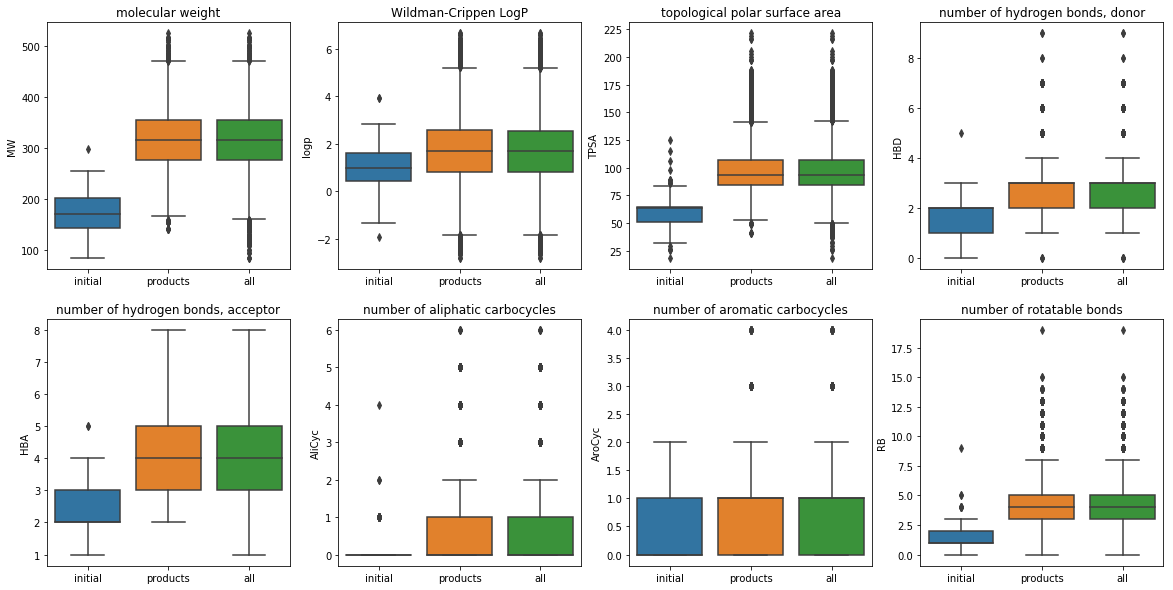

In [14]:
f, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=False)
ax1 = sns.boxplot(x="set", y="MW", data=cdf, ax=axes[0,0])
ax2 = sns.boxplot(x="set", y="logp", data=cdf, ax=axes[0,1])
ax3 = sns.boxplot(x="set", y="TPSA", data=cdf, ax=axes[0,2])
ax4 = sns.boxplot(x="set", y="HBD", data=cdf, ax=axes[0,3])
ax5 = sns.boxplot(x="set", y="HBA", data=cdf, ax=axes[1,0])
ax6 = sns.boxplot(x="set", y="AliCyc", data=cdf, ax=axes[1,1])
ax7 = sns.boxplot(x="set", y="AroCyc", data=cdf, ax=axes[1,2])
ax8 = sns.boxplot(x="set", y="RB", data=cdf, ax=axes[1,3])
ax1.set(xlabel='',title="molecular weight")
ax2.set(xlabel='',title="Wildman-Crippen LogP")
ax3.set(xlabel='',title="topological polar surface area")
ax4.set(xlabel='',title="number of hydrogen bonds, donor")
ax5.set(xlabel='',title="number of hydrogen bonds, acceptor")
ax6.set(xlabel='',title="number of aliphatic carbocycles")
ax7.set(xlabel='',title="number of aromatic carbocycles")
ax8.set(xlabel='',title="number of rotatable bonds")
plt.show()
f.savefig("properties.pdf", bbox_inches='tight')